# EE6347 Final Project

Authors: Kishore Rajendran (EE20B064), Shashidhar G Hegde (EE20B122)

Image classification on the EMNIST dataset using Convolutional Spiking Neural Network (SNN)

In [1]:
!pip install snntorch

In [2]:
# Importing required libraries
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools

<ipython-input-2-7671dbc64485>:4: DeprecationWarning: The module snntorch.backprop will be deprecated in  a future release. Writing out your own training loop will lead to substantially faster performance.
  from snntorch import backprop


# Loading and preprocessing the EMNIST dataset
* The EMNIST 'Balanced' dataset consists of 47 classes including both numbers and letters
* Aim: "The EMNIST datasets therefore provide a new classification
benchmark that contains more image samples, more output
classes, a more challenging classification task than MNIST whilst maintaining
its structure and nature" - [Source paper](https://arxiv.org/pdf/1702.05373v1.pdf)
* Since the dataset is itself large, we don't need to augment the datasets
* A train-val split of 0.8 is used for hyperparameter tuning
* Optimal batch size was obtained as 128

In [3]:
# Define transform to preprocess the data
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

# Loading the 'balanced' split of EMNIST dataset
emnist_dataset_train = datasets.EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform)
emnist_dataset_test = datasets.EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform)

# Splitting into train and validation sets
train_val_split = 0.8
train_size = int(train_val_split * len(emnist_dataset_train))
val_size = len(emnist_dataset_train) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(emnist_dataset_train, [train_size, val_size])

# Creating data loaders
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last = True)
test_loader = torch.utils.data.DataLoader(emnist_dataset_test, batch_size=batch_size, shuffle=True, drop_last = True)

# Printing sizes of the datasets
print(f"Size of the training dataset: {len(train_loader.dataset)}")
print(f"Size of the validation dataset: {len(val_loader.dataset)}")
print(f"Size of the test dataset: {len(test_loader.dataset)}")

Size of the training dataset: 90240
Size of the validation dataset: 22560
Size of the test dataset: 18800


torch.Size([128, 1, 28, 28])
Target class label: 44


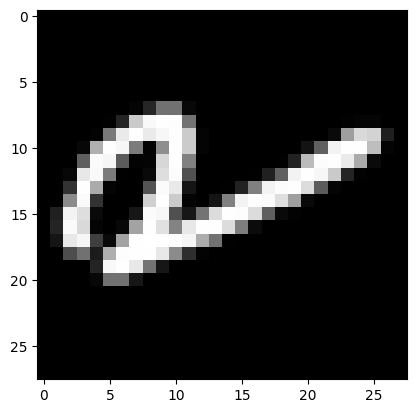

In [8]:
# Visualizing the test dataset
examples = enumerate(test_loader)
batch_idx, (data, targets) = list(examples)[0]

print(data.shape)
idx = 101
plt.imshow(data[idx][0],cmap='gray')
print(f"Target class label: {targets[idx]}")

# Defining the model architecture, Converting the data to spiking data

* Upon carefully experimenting with various surrogate functions and beta values, we have arrived at a set of optimal values for our neuron.

* Also, after comparing Rate coding, Latency coding and Delta modulation, we find that rate coding our data to create spiking data with num_steps = 10, gives us the highest accuracy

* The architecture of the convolutional SNN designed is inspired by the popular LeNet architecture

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# Neuron and simulation parameters
spike_grad = surrogate.atan(alpha=0.2)
beta = 0.2
num_steps = 10

# Defining the network architecture
net = nn.Sequential(nn.Conv2d(1, 12, 5),
                    nn.BatchNorm2d(12),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(12, 64, 5),
                    nn.BatchNorm2d(64),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Flatten(),
                    nn.Dropout(0.2),
                    nn.Linear(64*4*4, 64*4),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Dropout(0.2),
                    nn.Linear(64*4, 47),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

data, targets = next(iter(train_loader))
# Encoding the data using rate encoding
spike_data = spikegen.rate(data, num_steps=num_steps)
spike_data = spike_data.to(device)
print(data.size())
print(spike_data.size())
targets = targets.to(device)

for step in range(num_steps):
    spk_out, mem_out = net(data)

# Forward pass
def forward_pass(net, num_steps, spike_data):
  mem_rec = []
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(num_steps):
      spk_out, mem_out = net(spike_data[step])
      spk_rec.append(spk_out)
      mem_rec.append(mem_out)

  return torch.stack(spk_rec), torch.stack(mem_rec)

torch.Size([128, 1, 28, 28])
torch.Size([10, 128, 1, 28, 28])


Upon trying all the possible loss functions provided by snntorch, we found mse_count_loss() to work the best

In [7]:
loss_fn = SF.mse_count_loss()

In [9]:
# Defining the function for accuracy calculation
def batch_accuracy(train_loader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    train_loader = iter(train_loader)
    for data, targets in train_loader:
      spike_data = spikegen.rate(data, num_steps=num_steps)
      spike_data = spike_data.to(device)
      targets = targets.to(device)
      spk_rec, _ = forward_pass(net, num_steps, spike_data)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total

# The training loop
* Since each epoch takes a lot of time to run, we run only for 15 epochs
* After trying a couple of optimizers, we realized that the Adam optimizer works best in this case

In [10]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.999))
num_epochs = 15
loss_hist = []
train_acc_hist = []
test_acc_hist = []
counter = 0
total = 0
train_acc = 0
iter_train_acc = 0

# Outer training loop
for epoch in range(num_epochs):

    #Training loop
    for data, targets in iter(train_loader):
        spike_data = spikegen.rate(data, num_steps=num_steps)
        spike_data = spike_data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, _ = forward_pass(net, num_steps, spike_data)

        iter_train_acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
        total += spk_rec.size(1)
        train_acc = iter_train_acc/total
        train_acc_hist.append(train_acc)

        # initialize the loss & sum over time
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        if counter % 100 == 0:
          with torch.no_grad():
              net.eval()

              # Test set forward pass
              test_acc = batch_accuracy(val_loader, net, num_steps)
              print(f"Iteration {counter}, Train Acc: {train_acc * 100:.2f} , Val Acc: {test_acc * 100:.2f}%\n")
              test_acc_hist.append(test_acc.item())

        counter += 1

Iteration 0, Train Acc: 3.12 , Val Acc: 2.45%

Iteration 100, Train Acc: 41.43 , Val Acc: 68.21%

Iteration 200, Train Acc: 57.00 , Val Acc: 77.16%

Iteration 300, Train Acc: 64.28 , Val Acc: 80.41%

Iteration 400, Train Acc: 68.34 , Val Acc: 82.17%

Iteration 500, Train Acc: 71.03 , Val Acc: 83.49%

Iteration 600, Train Acc: 72.97 , Val Acc: 83.58%

Iteration 700, Train Acc: 74.47 , Val Acc: 84.73%

Iteration 800, Train Acc: 75.66 , Val Acc: 85.35%

Iteration 900, Train Acc: 76.63 , Val Acc: 85.08%

Iteration 1000, Train Acc: 77.47 , Val Acc: 85.51%

Iteration 1100, Train Acc: 78.21 , Val Acc: 85.59%

Iteration 1200, Train Acc: 78.82 , Val Acc: 85.85%

Iteration 1300, Train Acc: 79.35 , Val Acc: 85.81%

Iteration 1400, Train Acc: 79.85 , Val Acc: 86.01%

Iteration 1500, Train Acc: 80.26 , Val Acc: 85.78%

Iteration 1600, Train Acc: 80.61 , Val Acc: 86.63%

Iteration 1700, Train Acc: 80.93 , Val Acc: 86.25%

Iteration 1800, Train Acc: 81.25 , Val Acc: 86.59%

Iteration 1900, Train Acc:

[EMNIST-Balanced Test Accuracies](https://paperswithcode.com/sota/image-classification-on-emnist-balanced)


The attached link shows us that our accuracy is quite high and that the convolutional SNN is performing well.

As seen below, the final test accuracy obtained is 88.37%

In [11]:
with torch.no_grad():
  net.eval()
  # Test set forward pass
  test_acc = batch_accuracy(val_loader, net, num_steps)
  print(f" Test Acc: {test_acc * 100:.2f}%\n")
  test_acc_hist.append(test_acc.item())

 Test Acc: 88.37%



# Plotting Training Loss and Accuracy

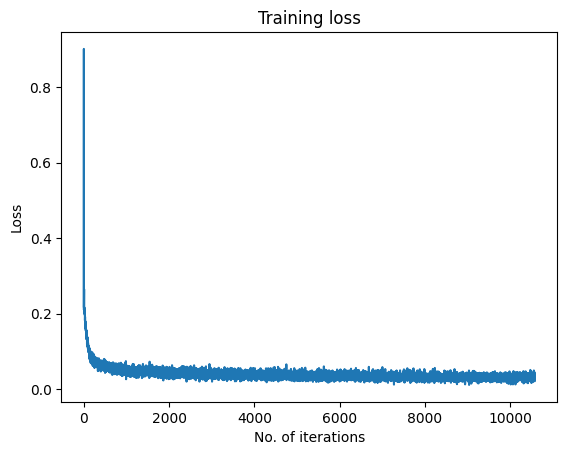

In [16]:
# Training Loss vs iterations plot
plt.plot(loss_hist)
plt.xlabel('No. of iterations')
plt.ylabel('Loss')
plt.title("Training loss")
plt.show()

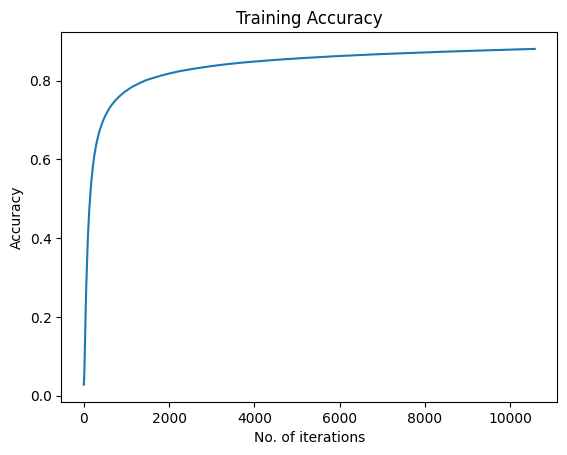

In [18]:
# Training Accuracy vs iterations plot
plt.plot(train_acc_hist)
plt.xlabel('No. of iterations')
plt.ylabel('Accuracy')
plt.title("Training Accuracy")
plt.show()